In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression,LassoCV, RidgeCV, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import ElasticNet
import seaborn as sns
import matplotlib.pyplot as plt
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
X_val = pd.read_csv('../datasets/clean_filled/xval_clean.csv',keep_default_na=False,na_values='')
X_train = pd.read_csv('../datasets/clean_filled/xtrain_clean.csv',keep_default_na=False,na_values='')
df_test = pd.read_csv('../datasets/clean_filled/test_clean.csv',keep_default_na=False,na_values='')
y_val = pd.read_csv('../datasets/clean_filled/yval_clean.csv',keep_default_na=False,na_values='')
y_train = pd.read_csv('../datasets/clean_filled/ytrain_clean.csv',keep_default_na=False,na_values='')

In [4]:
X_val.shape,X_train.shape,df_test.shape

((506, 77), (1516, 77), (878, 77))

In [5]:
test_id = df_test['id']

### Log Transforming y

Creating log transformations of the Sale Price data because of its skew. Will test during modeling whether it improves the accuracy of the model's predictions.

In [6]:
log_ytrain = np.log(y_train)
log_yval = np.log(y_val)

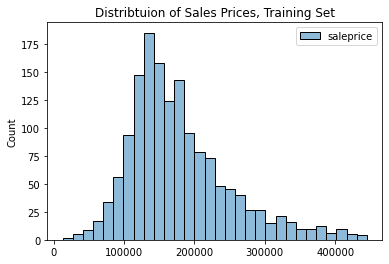

In [7]:
sns.histplot(y_train).set(title = 'Distribtuion of Sales Prices, Training Set');

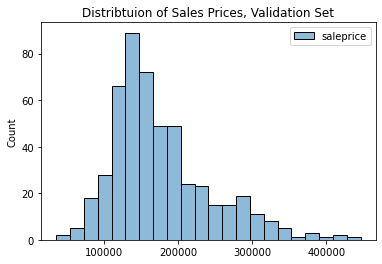

In [8]:
sns.histplot(y_val).set(title = 'Distribtuion of Sales Prices, Validation Set');

Below I take steps to split the data columns into the columns that will be treated as numerical and categorical when passed through the column transformer.

In [9]:
ordinal = ['overall_qual','overall_cond','exter_qual','exter_cond','bsmt_qual',\
    'bsmt_cond','bsmtfin_type_1','bsmtfin_type_2','heating_qc','electrical','kitchen_qual','functional',\
    'fireplace_qu','garage_finish','garage_qual','garage_cond','paved_drive','pool_qc','fence',\
    'lot_shape','utilities','land_slope','bsmt_exposure','area_qual']

In [10]:
num_as_cat = ['ms_subclass','bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr',\
             'garage_cars','mo_sold','yr_sold']

In [11]:
numeric = [col for col in X_train._get_numeric_data().columns if col not in ordinal and col not in num_as_cat]
categorical = [col for col in X_train.columns if col not in numeric]

# Preprocessing & Modeling

Below are the features that I dropped from my regression analysis.

The features I dropped to limit multicollinearity are below, identified through EDA:
* Garage cars, correlated to garage area.
* Garage condition, correlated to garage quality.
* Total rooms above ground/1st floor sq/2nd floor sq ..  correlated to above ground living area.
* Basement condition, correlated to basement quality.
* External quality, related to overall quality.
* Fireplace Quality, correlated to having a fireplace.

The remainder of the features were dropped through trial and error, finding what combination of features best explained the variance of sales price in the validation set of transactions. I took a very hands-on process in determining which features to include, and produced a model which generated results with an accuracy I was OK with, and with attention paid to the data science problem: what can our homeowners change in a matter of months. That being said, splitting data into what I deem can be changed/what cant be changed and then utilizing RFE would likely have contributed to the quicker identification of which features to include from a control standpoint, and which featurs to include from an inferential standpoint. However, when I arrived at a set of features that I felt answered my data science problem, with a model accuracy that I considered to be satisfactory, I elected not to proceed with utilizing further RFE.

In [12]:
extraneous = ['id','street','alley','lot_shape','bsmt_exposure','misc_val','misc_feature',\
             'pool_qc','bsmt_half_bath','bsmtfin_type_2',\
             'functional','low_qual_fin_sf','electrical',\
             'bsmtfin_sf_2','utilities',\
             'ms_zoning','mo_sold',\
             'enclosed_porch','kitchen_abvgr',\
             'heating','bsmt_unf_sf','bsmtfin_sf_1',\
             'roof_style','land_contour','ms_subclass', 'lot_frontage',
             'lot_config', 'land_slope', 'mas_vnr_type', 'mas_vnr_area',\
             'garage_type','exterior_2nd',\
             'area_qual','garage_finish','bsmtfin_type_1',\
             'yrs_sincerm','foundation',\
             'pool_area','roof_matl','exter_cond','3ssn_porch','screen_porch']             

multicoll = ['garage_cars','garage_cond','totrms_abvgrd','2nd_flr_sf','bsmt_cond', 'exter_qual','fireplace_qu',\
             '1st_flr_sf']


drops = extraneous + multicoll

Dropped same features for each set of observations.

In [13]:
Xtrain_d = X_train.drop(columns=drops)
Xval_d = X_val.drop(columns=drops)
dftest_d = df_test.drop(columns=drops)

The below are the features used for the regression modeling.

In [14]:
Xtrain_d.columns

Index(['lot_area', 'neighborhood', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'exterior_1st', 'bsmt_qual', 'total_bsmt_sf',
       'heating_qc', 'central_air', 'gr_liv_area', 'bsmt_full_bath',
       'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_qual', 'fireplaces',
       'garage_area', 'garage_qual', 'paved_drive', 'wood_deck_sf',
       'open_porch_sf', 'fence', 'yr_sold', 'sale_type', 'age'],
      dtype='object')

In [15]:
len(Xtrain_d.columns)

27

## Creating Null Baseline

Creating a null baseline to which we can compare the models we are building.

In [16]:
baseline_test = np.full_like(y_val,y_val.mean())
null_mse = mean_squared_error(y_val,baseline_test)
null_mae = mean_absolute_error(y_val,baseline_test)
null_rsme = np.sqrt(null_mse)
print('Baseline Test MSE is '+str(round(null_mse)))
print('Baseline Test RMSE is '+str(round(null_rsme)))
print('Baseline Test MAE is '+str(round(null_mae)))

Baseline Test MSE is 4417414053
Baseline Test RMSE is 66464
Baseline Test MAE is 51405


### Column Transformer

In [17]:
ctx = ColumnTransformer(
    [('ss',StandardScaler(),[i for i in numeric if i not in drops]),
    ('ohe',OneHotEncoder(handle_unknown='ignore',drop='first',sparse=False),\
    [i for i in categorical if i not in drops])],
    verbose_feature_names_out=False,
    remainder = 'passthrough'
)

##  LR Analysis

The preprocessing done on the data was scaling of all numeric values, and One-hot-encoding of the categorical. The OHE dropped the first generated column of each feature to be used in comparative analysis. After this preprocessing was done in the pipeline, I began the regression analyses.


### LR Pipeline

In [17]:
lr_pipe = Pipeline(
    [
    ('ct',ctx),
    ('tt',TransformedTargetRegressor(regressor=LinearRegression(),func=np.log,inverse_func=np.exp))
    ]
)

lr_pipe.fit(Xtrain_d,y_train)
lr_pipe.score(Xtrain_d,y_train), lr_pipe.score(Xval_d,y_val), cross_val_score(lr_pipe,Xtrain_d,y_train,scoring='r2',cv=5).mean()

(0.9333357692471745, 0.9140060355583414, 0.9160661805411564)

### LR Predictions

In [18]:
t_preds = lr_pipe.predict(Xtrain_d)
mean_squared_error(y_train,t_preds)

347960656.8388269

In [19]:
v_preds = lr_pipe.predict(Xval_d)
mean_squared_error(y_val,v_preds)

379870946.949519

### LR Scoring

Below are the R-squared values I calculated for the permutations of regressions I ran, with the strongest regression last.

The first set was straighforward linear regression.. which resulted in strong r-squared values, but slight overfit:

* Train Set: 0.92974
* Validation Set: 0.90198
* K-Folds Cross Validation: 0.9131


When polynomial transformation was added to preprocessing pipeline, the model became very overfit, and variance was greatly increased.

* Train Set: 0.999
* Validaton Set: -2.6531
* K-Folds Cross Validation: -0.3231


The best model utilized just the linear regression, with a log transformation of the target. The values are strong, with a slight overfit. It does not seem excessive. The mean squared error is less than a tenth of the baseline figure.

* Train Set: 0.9333
* Validaton Set: 0.9140
* K-Folds Cross Validation: 0.9161


* Validation MSE: 379,870,946
* Baseline MSE: 4,417,414,053

### Residual Analysis

In [20]:
t_resids = y_train - t_preds
v_resids = y_val - v_preds

#### Training Set

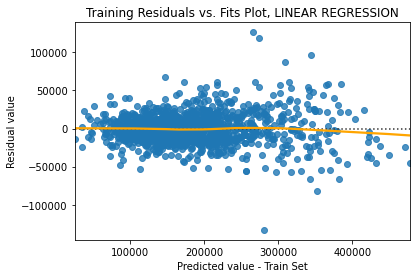

In [21]:
sns.residplot(x = t_preds,
              y = t_resids,
              lowess = True,
              line_kws = {'color':'orange'})\
    .set(title = 'Training Residuals vs. Fits Plot, LINEAR REGRESSION',
        xlabel = 'Predicted value - Train Set',
        ylabel = 'Residual value');

When reviewing the log transformed residuals for the training set, they are fairly evenly distributed accross the set of predicted values. Residuals tend to grow a bit larger around the $300K salesprice mark. For both the training and validation sets, there is a house for which our model predicted a sale price of much higher than actual price.

#### Validation Set

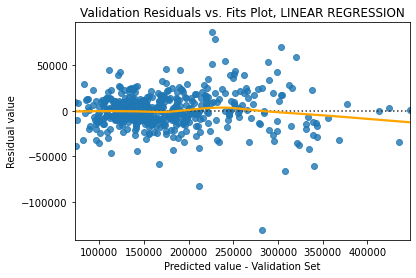

In [22]:
sns.residplot(x = v_preds,
              y = v_resids,
              lowess = True,
              line_kws = {'color':'orange'})\
    .set(title = 'Validation Residuals vs. Fits Plot, LINEAR REGRESSION',
        xlabel = 'Predicted value - Validation Set',
        ylabel = 'Residual value');

For the validation set, see that our predictions are fairly evenly distributed around 0 until the graph hits the $200K sale price mark. The model has an evident overfit element, when reviewed against the graph for the training set.

###  LR Coefficients

Calculated the coefficients using a formula provided by the University of Virginia for converting target log transformed coefficients into percentages. This is the basis for which we will arrive at interpretable coefficients for all of our model that have log transformed targets moving forward.

https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/

In [23]:
lrcoefs = lr_pipe.named_steps['tt'].regressor_.coef_.tolist()
lrcl = [(np.exp(i) - 1)*100 for i in lrcoefs]

lrn = lr_pipe.named_steps['ct'].get_feature_names_out().tolist()
lrnl = [i for i in lrn]

lrcoef_zip = zip(lrnl,lrcl)
lrcoef_dict = {a:b for a,b in lrcoef_zip}

#lrcoef_dict

## Ridge Analysis

### Ridge Gridsearch

In [24]:
ridge_pipe = Pipeline(
    [
    ('ct',ctx),
    ('ttr',TransformedTargetRegressor(regressor=Ridge(random_state=2),func=np.log,inverse_func=np.exp)),
    ]
)


ridgepipe_params = {
    'ttr__regressor__alpha' : [.001, .01, .1, .5, 1,10,100],
}


gsridge = GridSearchCV(
    ridge_pipe,
    ridgepipe_params,
    error_score = 'raise'
)


gsridge.fit(Xtrain_d,y_train)
gsridge.score(Xtrain_d,y_train),gsridge.score(Xval_d,y_val)

(0.9330167551127622, 0.9147101360382983)

In [25]:
gsridge.best_score_

0.9185124224119505

In [26]:
gsridge.best_params_

{'ttr__regressor__alpha': 0.5}

In [27]:
ridge_pipe2 = Pipeline(
    [
    ('ct',ctx),
    ('ttr',TransformedTargetRegressor(regressor=Ridge(random_state=2,alpha=.5),func=np.log,inverse_func=np.exp)),
    ]
)

ridge_pipe2.fit(Xtrain_d,y_train)
ridge_pipe2.score(Xtrain_d,y_train), ridge_pipe2.score(Xval_d,y_val), cross_val_score(ridge_pipe2,Xtrain_d,y_train,scoring='r2').mean()

(0.9330167551127622, 0.9147101360382983, 0.9185124224119505)

The gridsearch produced a better score of 91.47% r-squared on the validation set.

### Ridge Predictions

In [28]:
rt_preds = ridge_pipe2.predict(Xtrain_d)
mean_squared_error(y_train,rt_preds)

349625783.1966573

In [29]:
rv_preds = ridge_pipe2.predict(Xval_d)
mean_squared_error(y_val,rv_preds)

376760643.59502816

In [30]:
ridt_resids = y_train - rt_preds
ridv_resids = y_val - rv_preds

### Ridge Scoring

Below are the results from the Ridge regression analysis that was run, first with the default alphas, and then the final alpha number used, .5. Again, this data was scaled and one-hot-encoded.

Ridge with Default alphas:
* Train: 0.9321
* Validation: 0.9144
* K-Folds: 0.9177


Ridge with Default alphas and polynomial transformation. Again, model becomes much more overfit and has high variance.
* Train: 0.9875
* Validation: 0.8893
* K-Folds: 0.8899


Ridge with Default alphas and log transform target performs the best of the ridge regression run.
* Train: 0.9330
* Validation: 0.9147
* K-Folds: 0.9185

This is the best of the models run so far, with a lower MSE than the linear regression model. This is ultimately the model we proceed with for the final analysis presented.
* Ridge Validation MSE: 376,760,643
* LR Validation MSE: 379,870,946

#### Training Set

Again, with a few exceptions, the errors are fairly well distributed around the mean.

The model does look similarly overfit, with residuals starting to grow when we approach the 300K in the training set and  200K in the validation. The apparent overfit in the model remains.

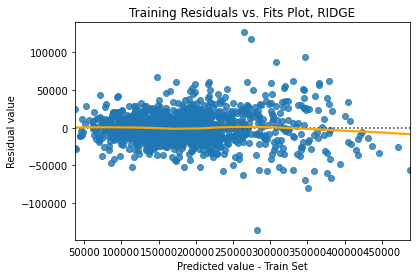

In [31]:
sns.residplot(x = rt_preds,
              y = ridt_resids,
              lowess = True,
              line_kws = {'color':'orange'})\
    .set(title = 'Training Residuals vs. Fits Plot, RIDGE',
        xlabel = 'Predicted value - Train Set',
        ylabel = 'Residual value');

#### Validation Set

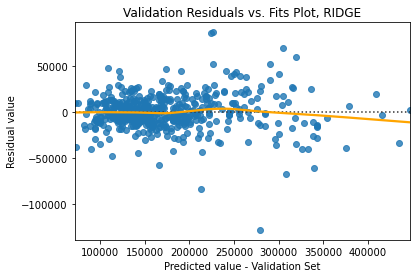

In [32]:
sns.residplot(x = rv_preds,
              y = ridv_resids,
              lowess = True,
              line_kws = {'color':'orange'})\
    .set(title = 'Validation Residuals vs. Fits Plot, RIDGE',
        xlabel = 'Predicted value - Validation Set',
        ylabel = 'Residual value');

#### Ridge Coefficients

The below ridge coefficients will be presented as final findings for this project.

In [28]:
ridgecoefs = ridge_pipe2.named_steps['ttr'].regressor_.coef_.tolist()
ridgecl = [(np.exp(i) - 1)*100 for i in ridgecoefs]

ridgenames = ridge_pipe2.named_steps['ct'].get_feature_names_out().tolist()
ridgenl = [i for i in ridgenames]

ridgecoef_zip = zip(ridgenl,ridgecl)
ridgecoef_dict = {a:b for a,b in ridgecoef_zip}

#ridgecoef_dict

## LASSO Analysis

### Lasso Gridsearch

In [43]:
lasso_pipe = Pipeline(
    [
    ('ct',ctx),
    ('ttr',TransformedTargetRegressor(regressor=Lasso(random_state=2),func=np.log,inverse_func=np.exp))
    ]
)

lassopipe_params = {
    'ttr__regressor__alpha' : [.00001,.0001, .001, .01, .01, 1,10,100],
}


gslasso = GridSearchCV(
    lasso_pipe,
    lassopipe_params,
    error_score = 'raise'
)


gslasso.fit(Xtrain_d,y_train)
gslasso.score(Xtrain_d,y_train),gslasso.score(Xval_d,y_val)

(0.933125712362749, 0.913739478466191)

In [44]:
gslasso.best_score_

0.9194251064697575

In [45]:
gslasso.best_params_

{'ttr__regressor__alpha': 0.0001}

### Lasso Scoring

Via Gridsearch, I identified the best performing Lasso model as using an Alpha of .0001. The results are below, which are worse than both the linear regression and Ridge regression on the validation r-squared metric.
* Train: 0.9331
* Val: 0.9137
* K Folds: 0.9194



## Elastic Net Analysis

The elastic net analysis did not produce as strong a model as our previous iterations, even when utilizing the polynomial transformation.

#### Elastic Net Piepline

In [19]:
enet_pipe = Pipeline(
    [
    ('ct',ctx),
    ('poly',PolynomialFeatures()),
    ('enet',ElasticNet())
    ]
)

enet_pipe_params = {
    'poly__degree' : [1,2],
}


gsenet = GridSearchCV(
    enet_pipe,
    enet_pipe_params,
    error_score = 'raise'
)

gsenet.fit(Xtrain_d,y_train)
gsenet.score(Xtrain_d,y_train), gsenet.score(Xval_d,y_val), cross_val_score(gsenet,Xtrain_d,y_train,scoring='r2').mean()

(0.9306417090326673, 0.9028970884675854, 0.9029690468821865)

#### Elastic Net Predictions

In [21]:
ent_preds = gsenet.predict(Xtrain_d)
mean_squared_error(y_train,ent_preds)

362022575.07019514

In [22]:
env_preds = gsenet.predict(Xval_d)
mean_squared_error(y_val,env_preds)

428943765.93602514

Ultimately it is the Ridge regression that will be chosen as the best predictor thas has been created.

### Graphs

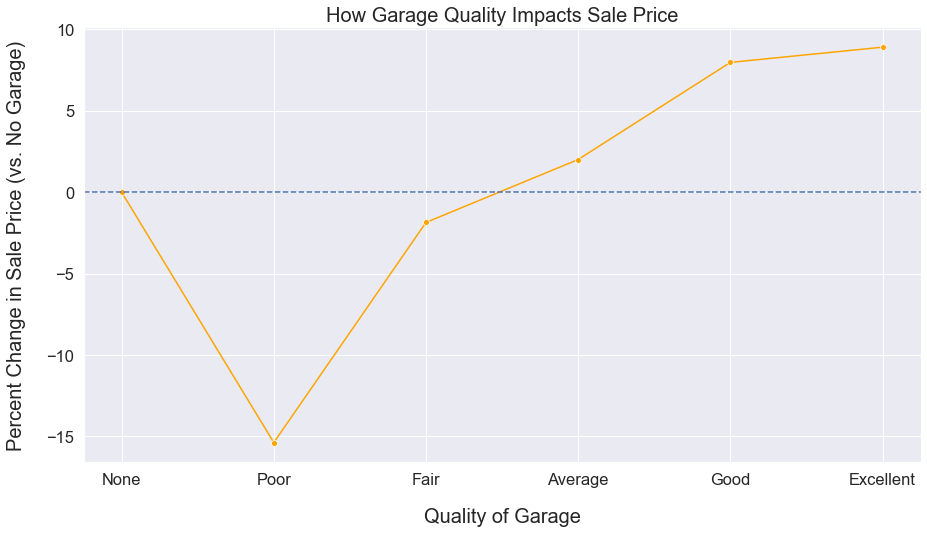

In [29]:
gq_coeffs = []
for k,v in ridgecoef_dict.items():
    if 'garage_qual' in k:
        gq_coeffs.append(v)
gq_coeffs.insert(0,0)
g_quals = ['None','Poor','Fair','Average','Good','Excellent']
sns.set(font_scale = 1.5)
plt.figure(figsize=(15,8))
sns.lineplot(x=g_quals,y=gq_coeffs,marker='o',color='orange').axhline(0,linestyle='--')
plt.ylabel('Percent Change in Sale Price (vs. No Garage)',fontsize=20,labelpad=20)
plt.xlabel('Quality of Garage',fontsize=20,labelpad=20)
plt.title('How Garage Quality Impacts Sale Price',fontsize=20);

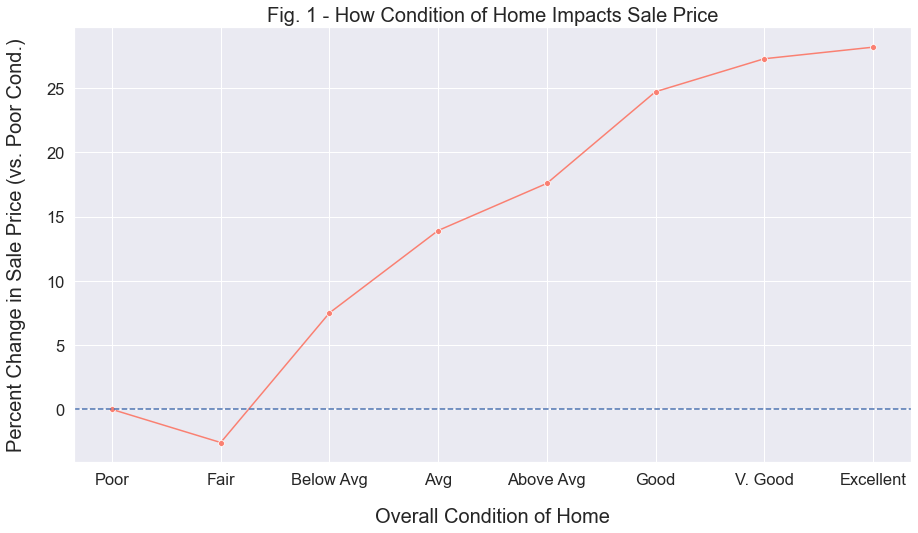

In [30]:
oc_coeffs = []
for k,v in ridgecoef_dict.items():
    if 'overall_cond' in k:
        oc_coeffs.append(v)
oc_coeffs[0] = 0
oc_coeffs
oc_conds = ['Poor','Fair','Below Avg','Avg','Above Avg','Good','V. Good','Excellent']
sns.set(font_scale = 1.5)
plt.figure(figsize=(15,8))
sns.lineplot(x=oc_conds,y=oc_coeffs,marker='o',color='salmon').axhline(0,linestyle='--')
plt.ylabel('Percent Change in Sale Price (vs. Poor Cond.)',fontsize=20,labelpad=20)
plt.xlabel('Overall Condition of Home',fontsize=20,labelpad=20)
plt.title('Fig. 1 - How Condition of Home Impacts Sale Price',fontsize=20);

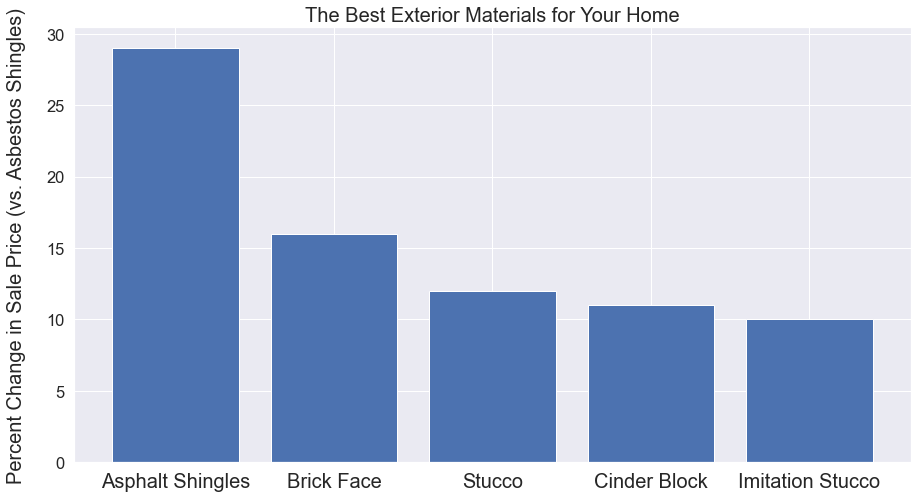

In [31]:
plt.figure(figsize=(15,8))
exter_improv = [29, 16, 12, 11, 10]
material = ['Asphalt Shingles', 'Brick Face', 'Stucco', 'Cinder Block', 'Imitation Stucco']
y_pos = np.arange(len(exter_improv))
plt.bar(y_pos, exter_improv)
plt.xticks(y_pos, material,fontsize=20)
plt.ylabel('Percent Change in Sale Price (vs. Asbestos Shingles)',fontsize=20,labelpad=20)
plt.title('The Best Exterior Materials for Your Home',fontsize=20)
plt.show();